In [17]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [22]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        tmp = []
        ff = 1
        for line in f.readlines():
            if ff:
                ff = 0
                continue
            d = json.loads(line)
            kk += d['l']
            tmp.append(d['r'][0])
            if kk > 50:
                ccnt += 1
                r['l'].append(ccnt*50)
                kk = kk % 50
                r['r'].append(np.mean(tmp))
                tmp = []
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys, er, rr):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
        if k == 'r':
            vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [23]:
def get_data(prefix, criterion, er, rr):

    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        for path in paths:
            files = glob.glob(path + '/seed-*/0.monitor.json')
            res = []
            for f in files:
                if not 'seed-10/' in f and not 'seed-12/' in f and not 'seed-14/' in f:
                    continue
                print (f)
                r = process_json(f)
                res.append(r)
            print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'], er=er, rr=rr)
            d[path] = res
        #print (path)
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [60]:
def plotArg(game, ax):
    env_id, traj_need = game.split('-')
    traj_need = int(traj_need)
    colors = colorPanel.colorPanel(1).getColors()

    
    #print gail
    d_type = ['single', 'decentralized']#, 'centralized']
    plot_type = {'single': 'Cooperative', 'decentralized': 'Decentralized', 500: '', 0: '+BC'}
    bc_iter = [500]
    
    cnt = 0
    
    expert_reward = -13.5
    random_reward = -43
    
    for i in d_type:
        for j in bc_iter:
            datas = get_data(prefix='/atlas/u/hyren/exps', criterion='gail/%s/%s/s-%d/l-0.1-b-1000-d-0.1-c-%d/'%(env_id, i, traj_need, j),
                            er = expert_reward, rr = random_reward)
            label = '%s%s' % (plot_type[i], plot_type[j])

            
            x = datas['l']
            y = datas['r']

            x = x[0]
            y_mean = y[0]
            y_std = y[1]

            xx = x
            x, y_mean = smooth_reward_curve(xx, y_mean)
            x, y_std = smooth_reward_curve(xx, y_std)
            x = x * 1e7 / np.max(x)

            cnt += 1
            color = colors[cnt]

            y_upper = y_mean + y_std
            y_lower = y_mean - y_std
            ax.fill_between(
                x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), label=label, color=color, rasterized=True, linewidth=2.0)          

    
    #print mack
    '''
    datas = get_data(prefix='/atlas/u/hyren/exps', criterion='mack/%s/l-0.1-b-1000/'%(env_id))
    label = 'mack'
    x = datas['l']
    y = datas['r']

    x = x[0]
    y_mean = y[0]
    y_std = y[1]

    xx = x
    x, y_mean = smooth_reward_curve(xx, y_mean)
    x, y_std = smooth_reward_curve(xx, y_std)
    x = x * 1e7 / np.max(x)
    

    y_upper = y_mean + y_std
    y_lower = y_mean - y_std
    ax.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[0], linewidth=0.0, alpha=0.3
    )
    line = ax.plot(x, list(y_mean), label=label, color=colors[0], rasterized=True)         
    '''
    #print bc
#     y_upper = np.repeat(0 + 4/(expert_reward-random_reward), len(x)) 
#     y_lower = np.repeat(0 - 4/(expert_reward-random_reward), len(x))
#     ax.fill_between(
#         x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[-1], linewidth=0.0, alpha=0.3
#     )
    line = ax.plot(x, list(np.repeat(0, len(x))), '--', label='BC', linewidth=2.0, color=colors[-1], rasterized=True)
    #print expert
    line = ax.plot(x, list(np.repeat(1, len(x))), '--', label='Expert', linewidth=2.0, color=colors[-2], rasterized=True)        
    
    game = 'Cooperative Navigation'
    stick.cutsomStick(game, 'timesteps', ax)
    if args == 'Reacher':
        ax.set_ylim(-10, 0)
    #ax.set_ylim(-70,0)

(['gail/simple_spread/single/s-400/l-0.1-b-1000-d-0.1-c-500/'], 'gail/simple_spread/single/s-400/l-0.1-b-1000-d-0.1-c-500/')
gail/simple_spread/single/s-400/l-0.1-b-1000-d-0.1-c-500/seed-10/0.monitor.json
gail/simple_spread/single/s-400/l-0.1-b-1000-d-0.1-c-500/seed-14/0.monitor.json
gail/simple_spread/single/s-400/l-0.1-b-1000-d-0.1-c-500/seed-12/0.monitor.json
3
43887
43887
(['gail/simple_spread/decentralized/s-400/l-0.1-b-1000-d-0.1-c-500/'], 'gail/simple_spread/decentralized/s-400/l-0.1-b-1000-d-0.1-c-500/')
gail/simple_spread/decentralized/s-400/l-0.1-b-1000-d-0.1-c-500/seed-12/0.monitor.json
gail/simple_spread/decentralized/s-400/l-0.1-b-1000-d-0.1-c-500/seed-10/0.monitor.json
gail/simple_spread/decentralized/s-400/l-0.1-b-1000-d-0.1-c-500/seed-14/0.monitor.json
3
43818
43818


TypeError: cutsomStick() got an unexpected keyword argument 'fontsize'

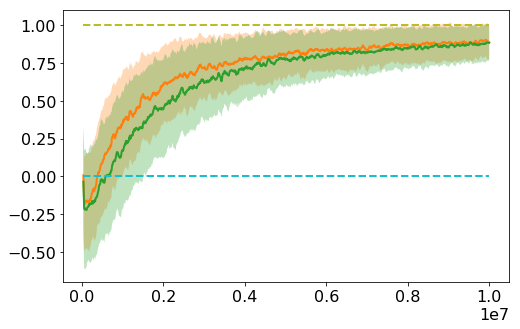

In [61]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
columns = 1
sixAtariGames = [
     #'simple_spread-100',
     #'simple_spread-200',
     #'simple_spread-300',
     'simple_spread-400',
]

# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')


for i, args in enumerate(sixAtariGames):
    #print(args)
    #ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    #ax = fig.add_subplot(1, 1, 1)
    plotArg(args, ax)

#plt.legend(loc=4)

lgd = plt.legend(prop={'size': 20}, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4)

ax.set_xlabel('Number of Timesteps')
ax.set_ylabel('Episode Rewards')

fig.tight_layout()
#fig.savefig('complexity_spread.pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('spread.pdf', dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')